In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

In [2]:
le = LabelEncoder()
images = []
labels = []

training_path = 'data/raw/character_set1/training_data/'
testing_path = 'data/raw/character_set1/testing_data/'


In [3]:
dir_list = os.listdir(training_path)
for i in dir_list:
  dir = os.path.join(training_path, i)
  file_list = os.listdir(dir)
  for j in file_list:
    files = os.path.join(dir, j)
    img = cv2.imread(files)
    img = cv2.resize(img, (64,64))
    img = np.array(img, dtype=np.float32)
    img = img/255
    images.append(img)
    labels.append(i)

## Print out details of X and y

In [4]:
X = np.array(images)
print("len(X): ",len(X))
print("X.shape: ", X.shape)

y = np.array(labels)
print("len(y): ",len(y))
print("y.shape: ", y.shape)


len(X):  20628
X.shape:  (20628, 64, 64, 3)
len(y):  20628
y.shape:  (20628,)


In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
X_sh, y_sh = shuffle(X, y, random_state=42)

# Create Keras model
create a neural network model

In [6]:
model = Sequential()

In [7]:
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=36, activation='softmax'))

/Users/nattapat/Library/Python/3.11/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])


Epoch 1/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5697 - loss: 1.5780 - val_accuracy: 0.9237 - val_loss: 0.2857
Epoch 2/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9310 - loss: 0.2333 - val_accuracy: 0.9321 - val_loss: 0.2290
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9512 - loss: 0.1468 - val_accuracy: 0.9450 - val_loss: 0.2007
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9592 - loss: 0.1185 - val_accuracy: 0.9481 - val_loss: 0.1738
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9682 - loss: 0.0816 - val_accuracy: 0.9532 - val_loss: 0.1579
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9697 - loss: 0.0791 - val_accuracy: 0.9457 - val_loss: 0.1800
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9748 - loss: 0.0657 - val_accuracy: 0.9576 - val_loss: 0.1556
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9785 - loss: 0.0548 - 

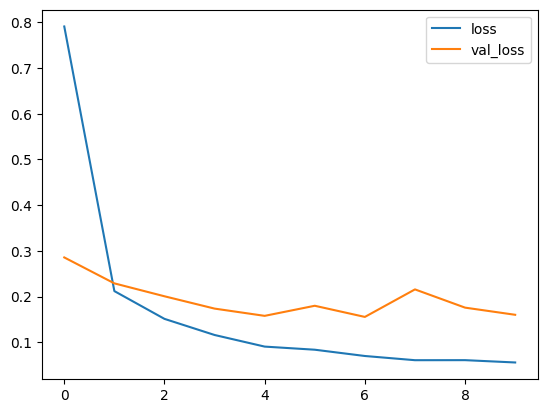

In [9]:
history = model.fit(X_sh, y_sh ,validation_split=0.2, batch_size=25, epochs=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [10]:
test_images = []
test_labels = []

dir_list = os.listdir(testing_path)
for i in dir_list:
  dir = os.path.join(testing_path, i)
  file_list = os.listdir(dir)
  for j in file_list:
    files = os.path.join(dir, j)
    img = cv2.imread(files)
    img = cv2.resize(img, (64,64))
    img = np.array(img, dtype=np.float32)
    img = img/255
    test_images.append(img)
    test_labels.append(i)

In [11]:
X_test = np.array(test_images)
y_test = np.array(test_labels)
le = LabelEncoder()
y_test = le.fit_transform(y_test) 

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_loss,test_accuracy )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9804 - loss: 0.0604 
0.04556874558329582 0.9851190447807312


In [13]:
def detect_text_regions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    # Find contours (regions of characters)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        regions.append((x-1, y-16, w+1, h+16))    
    return regions

In [14]:
def sort_bounding_boxes(regions):
    # Sort by `y` first (top-to-bottom) with a threshold to group by rows
    row_threshold = 20  # Adjust based on character spacing
    regions = sorted(regions, key=lambda box: box[1])

    # Group bounding boxes into rows
    rows = []
    current_row = [regions[0]]
    
    for i in range(1, len(regions)):
        if abs(regions[i][1] - current_row[-1][1]) < row_threshold:
            current_row.append(regions[i])
        else:
            rows.append(current_row)
            current_row = [regions[i]]
    rows.append(current_row)
    
    # Sort each row left-to-right
    sorted_regions = []
    for row in rows:
        sorted_row = sorted(row, key=lambda box: box[0])
        sorted_regions.extend(sorted_row)
    
    return sorted_regions


In [ ]:
def recognize_characters(image, model, label_encoder):
    regions = detect_text_regions(image)
    sorted_regions = sort_bounding_boxes(regions)
    # print(sorted_regions)

    characters = []
    for (x, y, w, h) in sorted_regions:
        char_image = image[y:y+h, x:x+w]
        char_image_resized = cv2.resize(char_image, (64, 64))
        char_image_normalized = char_image_resized / 255.0

        cv2.imshow('image after resized',char_image_normalized)
        cv2.waitKey(0)  # Wait indefinitely for a key press
        cv2.destroyAllWindows() 
        prediction = model.predict(np.expand_dims(char_image_normalized, axis=0))
        predicted_class = np.argmax(prediction, axis=1)
        predicted_char = label_encoder.inverse_transform(predicted_class)[0]
        #To be dicided later #If the current character is 'i' or 'j' we will
        #pop the lastest element out (which is supposed to be the dot above small i and j)

        # ----- UNCOMMENT LATER -----
        # if predicted_char == 'i' or predicted_char == 'j'
        #     characters.pop()
        
        characters.append(predicted_char)

    return characters


imggg = 'data/raw/character_set1/Test_2.png'
image = cv2.imread(imggg) 
y_pred = recognize_characters(image, model, le)
print(y_pred)
print(len(y_pred))

2024-11-17 02:21:57.304 Python[83750:788122] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
